# Ejemplo 1. Visualizacion y predicción de Creación de empresas en Murcia

En este ejemplo vamos a ver como podemos obtener informacion del Boletin Oficial del Registro Mercantil, procesarla y usar una librería de analisis de Series temporales para predecir y visualizar la tendencia de creación de empresas en Murcia en el 2018


Usaremos [tika](https://github.com/chrismattmann/tika-python) para la extracion de datos y [prophet](https://facebookincubator.github.io/prophet/) para el analisis de series temporales.

# Definición del problema.

Una Gestoría de la ciudad de Murcia quiere planificar su estrategia de contratacion de especialistas en Constitución de Sociedades. Para ello necesita saber el numero aproximado de Empresas creadas en la Ciudad de Murcia en 2018.

# Obtención de datos.

Para obtener los datos usaremos el script [parse_borme.py](/edit/Ejemplo1/parse_borme.py) que procesa los pdfs del Boletin Oficial del Registro Mercantil y guarda los registros en un archivo.

Lo usamos como

```
python parse_borme.py INICIO_FECHA FIN_FECHA REGIONES OUTPUT
```

Donde

- `INICIO_FECHA` es la fecha de inicio que queremos obtener
- `FIN_FECHA` es la fecha final que queremos obtener
- `REGIONES` es una lista de ciudades que nos interesan separadas por comas, por ejemplo `MURCIA,MADRID`
- `OUTPUT` es el nombre del archivo donde guardar los registros obtenidos

```
python parse_borme.py 2009-01-01 2017-04-01 MURCIA borme_filìngs.jsonl
```

# Procesamiento de Datos

In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet


In [ ]:
%matplotlib inline

In [2]:
with open("borme_fillings.jsonl") as fname:
    lines = fname.readlines()
    rows = [json.loads(l) for l in lines]
    df = pd.DataFrame(rows)

# Convertimos el string de la fecha en un objeto de python para poder agregar los datos

In [4]:
df['date'] = pd.to_datetime(df.date)

In [132]:
df.head()

,actions,date,raw,region,title
0,"[{'action_type': 'Fe de erratas:', 'action_des...",2009-01-02,2352 - TIC PRODATA CONSULTORES SLNE.\nFe de er...,MURCIA,2352 - TIC PRODATA CONSULTORES SLNE.
1,[{'action_type': 'Modificaciones estatutarias....,2009-01-02,2353 - ESTRUCTURAS MABELSA SLL.\nModificacione...,MURCIA,2353 - ESTRUCTURAS MABELSA SLL.
2,"[{'action_type': 'Nombramientos.', 'action_des...",2009-01-02,2354 - HORMIGONES MAR MENOR SL.\nNombramientos...,MURCIA,2354 - HORMIGONES MAR MENOR SL.
3,"[{'action_type': 'Ceses/Dimisiones.', 'action_...",2009-01-02,2355 - FORUM SAN PATRICIO SA.\nCeses/Dimisione...,MURCIA,2355 - FORUM SAN PATRICIO SA.
4,"[{'action_type': 'Ceses/Dimisiones.', 'action_...",2009-01-02,2356 - INVERSIONES PRADESUR SL.\nCeses/Dimisio...,MURCIA,2356 - INVERSIONES PRADESUR SL.


# vemos la columna `actions`. Como podemos ver, en cada registro puede haber múltiples acciones

In [29]:
df.iloc[0].actions

[{'action_description': '  Al publicar la transformación de SLNE en SL por error no se hizo constar el cambio del número de Hoja, siendo el\nnuevo MU-69.992.  ',
  'action_type': 'Fe de erratas:'},
 {'action_description': ' T 2646 , F 125, S 8, H MU 69992, I/A 1 (19.11.08).',
  'action_type': 'Datos registrales.'}]

# Nos interesan solo las constituciones de empresas, asi que filtramos todos los datos para tener solo aquellos con la acción `Constitución`

In [31]:
constituciones = (
    df[
        df.actions.map(
            lambda actions: "Constitución." in [action['action_type'] for action in actions]
        )
        ]
)

In [32]:
constituciones.head()

,actions,date,raw,region,title
7,"[{'action_type': 'Constitución.', 'action_desc...",2009-01-02,2359 - TRIVAL ARTES GRAFICAS SL.\nConstitución...,MURCIA,2359 - TRIVAL ARTES GRAFICAS SL.
9,"[{'action_type': 'Constitución.', 'action_desc...",2009-01-02,2361 - CAÑASURESTE MEDITERRANEA SL.\nConstituc...,MURCIA,2361 - CAÑASURESTE MEDITERRANEA SL.
11,"[{'action_type': 'Constitución.', 'action_desc...",2009-01-02,2363 - GRUPO EMPRESARIAL EXTENSA SOCIEDAD LIMI...,MURCIA,2363 - GRUPO EMPRESARIAL EXTENSA SOCIEDAD LIMI...
28,"[{'action_type': 'Constitución.', 'action_desc...",2009-01-02,2380 - EL CORTIJO DE RAYMAN SL.\nConstitución....,MURCIA,2380 - EL CORTIJO DE RAYMAN SL.
29,"[{'action_type': 'Constitución.', 'action_desc...",2009-01-02,"2381 - GESTION TRAUMATOLOGICA, SOCIEDAD LIMITA...",MURCIA,"2381 - GESTION TRAUMATOLOGICA, SOCIEDAD LIMITADA."


Agregamos todas las constituciones por semana

In [124]:
constituciones_dia = (
    constituciones
    .set_index('date')
    .resample('W')
    .count()
)[['actions']].reset_index()

Prophet necesita dos columnas, la columna `ds` que tiene la fecha y la columna `y` que tiene la variable dependiente que queremos medir

In [125]:
constituciones_dia.columns = ['ds', 'y']
constituciones_dia.head()

,ds,y
0,2009-01-04,12
1,2009-01-11,36
2,2009-01-18,43
3,2009-01-25,54
4,2009-02-01,56


# Predicción con Analisis de Series Temporales

In [126]:
m = Prophet()
m.fit(constituciones_dia);

In [127]:
future = m.make_future_dataframe(periods=60, freq="W")

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
484,2018-04-15,62.272408,44.554845,78.141271
485,2018-04-22,62.333309,45.324618,80.186578
486,2018-04-29,55.761634,38.421435,73.579327
487,2018-05-06,48.589669,30.773234,65.251925
488,2018-05-13,48.395376,32.356074,65.739247


*`yhat` es la predicción para el periodo `ds`, y `yhat_lower` y `yhat_upper` son los intervalos de confianza*

# Visualización de datos

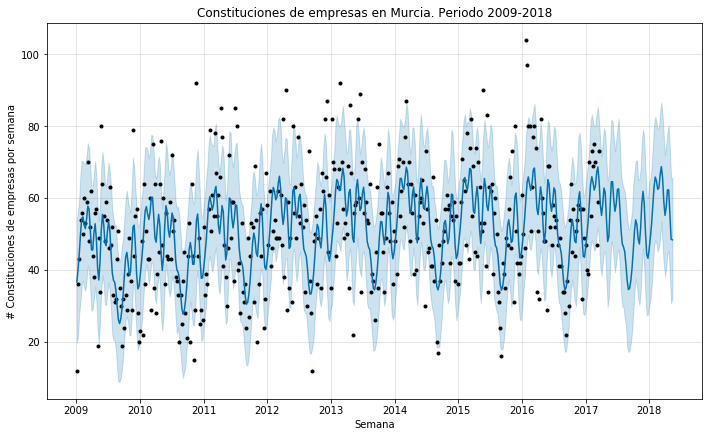

In [131]:
m.plot(forecast)
plt.title("Constituciones de empresas en Murcia. Periodo 2009-2018")
plt.xlabel("Semana")
plt.ylabel("# Constituciones de empresas por semana");